<a href="https://colab.research.google.com/github/MapsaBootCamp/ML1_excercise/blob/w24-hosein/Hosein_CartPole_DQN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setup

In [1]:
# !pip install tf-agents[reverb]

In [2]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import reverb

import tensorflow as tf

from tf_agents.agents.dqn import dqn_agent
from tf_agents.drivers import py_driver
from tf_agents.environments import suite_gym
from tf_agents.environments import tf_py_environment
from tf_agents.eval import metric_utils
from tf_agents.metrics import tf_metrics
from tf_agents.networks import sequential
from tf_agents.policies import py_tf_eager_policy
from tf_agents.policies import random_tf_policy
from tf_agents.replay_buffers import reverb_replay_buffer
from tf_agents.replay_buffers import reverb_utils
from tf_agents.trajectories import trajectory
from tf_agents.specs import tensor_spec
from tf_agents.utils import common

## Hyperparameters

In [3]:
num_iterations = 10000

initial_collect_steps = 100
collect_steps_per_iteration =   1
replay_buffer_max_length = 100000

batch_size = 64
learning_rate = 1e-3 
log_interval = 200 

num_eval_episodes = 10 
eval_interval = 1000

## Environment

In [4]:
env_name = 'CartPole-v0'
env = suite_gym.load(env_name)
train_py_env = suite_gym.load(env_name)
eval_py_env = suite_gym.load(env_name)

In [5]:
train_env = tf_py_environment.TFPyEnvironment(train_py_env)
eval_env = tf_py_environment.TFPyEnvironment(eval_py_env)

## Agent

In [6]:
fc_layer_params = (100, 50)
action_tensor_spec = tensor_spec.from_spec(env.action_spec())
num_actions = action_tensor_spec.maximum - action_tensor_spec.minimum + 1

def dense_layer(num_units):
  return tf.keras.layers.Dense(
      num_units,
      activation=tf.keras.activations.relu,
      kernel_initializer=tf.keras.initializers.VarianceScaling(
          scale=2.0, mode='fan_in', distribution='truncated_normal'))

dense_layers = [dense_layer(num_units) for num_units in fc_layer_params]
q_values_layer = tf.keras.layers.Dense(
    num_actions,
    activation=None,
    kernel_initializer=tf.keras.initializers.RandomUniform(
        minval=-0.03, maxval=0.03),
    bias_initializer=tf.keras.initializers.Constant(-0.2))

q_net = sequential.Sequential(dense_layers + [q_values_layer])

In [7]:
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

train_step_counter = tf.Variable(0)

agent = dqn_agent.DqnAgent(
    train_env.time_step_spec(),
    train_env.action_spec(),
    q_network=q_net,
    optimizer=optimizer,
    td_errors_loss_fn=common.element_wise_squared_loss,
    train_step_counter=train_step_counter)

agent.initialize()

## Policies

In [8]:
eval_policy = agent.policy
collect_policy = agent.collect_policy

## Metrics and Evaluation

In [9]:
def compute_avg_return(environment, policy, num_episodes=10):

  total_return = 0.0
  for _ in range(num_episodes):

    time_step = environment.reset()
    episode_return = 0.0

    while not time_step.is_last():
      action_step = policy.action(time_step)
      time_step = environment.step(action_step.action)
      episode_return += time_step.reward
    total_return += episode_return

  avg_return = total_return / num_episodes
  return avg_return.numpy()[0]


## Replay Buffer

In [10]:
table_name = 'uniform_table'
replay_buffer_signature = tensor_spec.from_spec(
      agent.collect_data_spec)
replay_buffer_signature = tensor_spec.add_outer_dim(
    replay_buffer_signature)

table = reverb.Table(
    table_name,
    max_size=replay_buffer_max_length,
    sampler=reverb.selectors.Uniform(),
    remover=reverb.selectors.Fifo(),
    rate_limiter=reverb.rate_limiters.MinSize(1),
    signature=replay_buffer_signature)

reverb_server = reverb.Server([table])

replay_buffer = reverb_replay_buffer.ReverbReplayBuffer(
    agent.collect_data_spec,
    table_name=table_name,
    sequence_length=2,
    local_server=reverb_server)

rb_observer = reverb_utils.ReverbAddTrajectoryObserver(
  replay_buffer.py_client,
  table_name,
  sequence_length=2)

## Data Collection

In [ ]:
random_policy = random_tf_policy.RandomTFPolicy(train_env.time_step_spec(),
                                                train_env.action_spec())

_ = py_driver.PyDriver(
      env,
      py_tf_eager_policy.PyTFEagerPolicy(
        random_policy, use_tf_function=True),
      [rb_observer],
      max_steps=initial_collect_steps).run(train_py_env.reset())

In [12]:
dataset = replay_buffer.as_dataset(
    num_parallel_calls=3,
    sample_batch_size=batch_size,
    num_steps=2).prefetch(3)

iterator = iter(dataset)

## Training the agent

In [13]:
agent.train = common.function(agent.train)

agent.train_step_counter.assign(0)

avg_return = compute_avg_return(eval_env, agent.policy, num_eval_episodes)
returns = [avg_return]

time_step = train_py_env.reset()

collect_driver = py_driver.PyDriver(
    env,
    py_tf_eager_policy.PyTFEagerPolicy(
      agent.collect_policy, use_tf_function=True),
    [rb_observer],
    max_steps=collect_steps_per_iteration)

for _ in range(num_iterations):

  time_step, _ = collect_driver.run(time_step)

  experience, unused_info = next(iterator)
  train_loss = agent.train(experience).loss

  step = agent.train_step_counter.numpy()

  if step % log_interval == 0:
    print('step = {0}: loss = {1:2.4f}'.format(step, train_loss))

  if step % eval_interval == 0:
    avg_return = compute_avg_return(eval_env, agent.policy, num_eval_episodes)
    print('step = {0}: Average Return = {1:2.4f}'.format(step, avg_return))
    returns.append(avg_return)

Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.foldr(fn, elems, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.foldr(fn, elems))
step = 200: loss = 10.3967
step = 400: loss = 49.5052
step = 600: loss = 302.3179
step = 800: loss = 213.1384
step = 1000: loss = 6357.2827
step = 1000: Average Return = 200.0000
step = 1200: loss = 175.6091
step = 1400: loss = 1399.5199
step = 1600: loss = 667.0668
step = 1800: loss = 4020.1060
step = 2000: loss = 3128.8320
step = 2000: Average Return = 115.9000
step = 2200: loss = 16002.2090
step = 2400: loss = 63618.3281
step = 2600: loss = 9609.5918
step = 2800: loss = 6575.4712
step = 3000: loss = 22243.6602
step = 3000: Average Return = 35.1000
step = 3200: loss = 3197.8413
step = 3400: loss = 32304.0859
step = 3600: loss = 4124.2441
step = 3800: loss = 1218.8135
step = 4000: loss = 1316.8337
step = 4000: Average Return = 75.5000
step = 4200: loss = 

## Visualization


(4.699999999999999, 250.0)

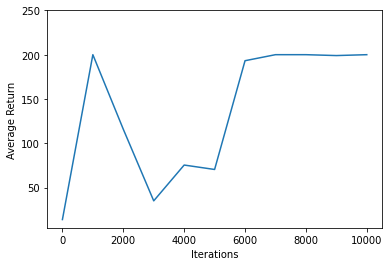

In [14]:
iterations = range(0, num_iterations + 1, eval_interval)
plt.plot(iterations, returns)
plt.ylabel('Average Return')
plt.xlabel('Iterations')
plt.ylim(top=250)